# Fine Tuning ResNet50 for ICB

In [1]:
import gc
import lib
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras as kr

%matplotlib inline
gc.collect()

[03:48:35] Library functions loaded.


26

[03:48:38] Loaded custom functions.
[03:48:38] Loading regular data sets...
Found 248 images belonging to 2 classes.
Found 144 images belonging to 2 classes.
Found 70 images belonging to 2 classes.
[03:48:38] Loading augmented data sets...
Found 248 images belonging to 2 classes.
[03:48:38] Loaded existing dataset & performed data augmentation.
[03:48:38] Displaying first 1 batches of the augmented_train_set VS train_set:


C:\ProgramData\Anaconda3\envs\ICB\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


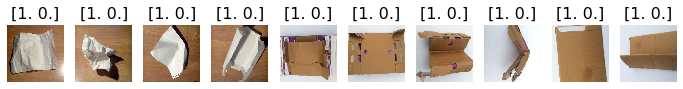

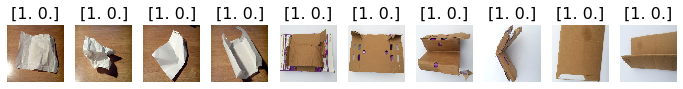

[03:48:39] Data Augmentation & Dataset loading completed!
	Time taken:  1.3284938335418701


In [2]:
# Implementation Dependant Globals
REQUIRED_DIMENSIONS = (300, 300)
TRAIN_BATCH_SIZE = 10
VALIDATION_BATCH_SIZE = 10
TEST_BATCH_SIZE = 10
N_AUG_VS_TEST = 1

# Import dataset
%run DataAugmentation.ipynb 

#### Fetch & Download ResNet50

In [3]:
# Fetch ResNet50 implementation from keras
resnet50 = kr.applications.resnet50
ResNet50 = resnet50.ResNet50

resnet_model = ResNet50(
    weights='imagenet', 
    include_top=False, 
    input_shape= REQUIRED_DIMENSIONS + (3,)
)

#### Build Fine Tuned Model

In [4]:
# Ease of Access
Model, Dropout, Flatten, Dense = kr.models.Model, kr.layers.Dropout, kr.layers.Flatten, kr.layers.Dense

CLASSES = ["biofuel", "non_biofuel"]
FC_LAYERS = [1024, 1024]
dropout = 0.5

for layer in resnet_model.layers:
    layer.trainable = False

output = resnet_model.output
output = Flatten()(output)

for fc in FC_LAYERS:
    # New FC layer, random init
    output = Dense(fc, activation='relu')(output) 
    output = Dropout(dropout)(output)

# New softmax layer
predictions = Dense(len(CLASSES), activation='softmax')(output) 

# Finally join everything
model = Model(inputs=resnet_model.input, outputs=predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

#### Train Model - Warmup

In [5]:
model.compile(
    kr.optimizers.SGD(lr=0.0001, momentum=0.9), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

history_1 = model.fit_generator(
    train_set, 
    epochs=15, 
    workers=8, 
    steps_per_epoch=train_set.samples/train_set.batch_size, 
    shuffle=True,
)

Epoch 1/15
25/24 [==============================] - 16s 644ms/step - loss: 1.6317 - accuracy: 0.6008
Epoch 2/15
25/24 [==============================] - 13s 516ms/step - loss: 1.1443 - accuracy: 0.7903
Epoch 3/15
25/24 [==============================] - 13s 509ms/step - loss: 0.3518 - accuracy: 0.9153
Epoch 4/15
25/24 [==============================] - 13s 524ms/step - loss: 0.1410 - accuracy: 0.9637
Epoch 5/15
25/24 [==============================] - 13s 529ms/step - loss: 0.1229 - accuracy: 0.9677
Epoch 6/15
25/24 [==============================] - 13s 517ms/step - loss: 0.0518 - accuracy: 0.9758
Epoch 7/15
25/24 [==============================] - 13s 516ms/step - loss: 0.0866 - accuracy: 0.9718
Epoch 8/15
25/24 [==============================] - 13s 511ms/step - loss: 0.0306 - accuracy: 0.9839
Epoch 9/15
25/24 [==============================] - 13s 514ms/step - loss: 0.0400 - accuracy: 0.9798
Epoch 10/15
25/24 [==============================] - 13s 521ms/step - loss: 0.0081 - accura

#### Train Model - Final

In [6]:
# Reset validaiton & train set generators
train_set.reset()
validation_set.reset()

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
for layer in model.layers[:172]:
   layer.trainable = False
for layer in model.layers[172:]:
   layer.trainable = True

model.compile(
    kr.optimizers.SGD(lr=0.0001, momentum=0.9), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

history_2 = model.fit_generator(
    train_set, 
    epochs=20, 
    workers=8, 
    steps_per_epoch=train_set.samples/train_set.batch_size, 
    shuffle=True,
)

Epoch 1/20
25/24 [==============================] - 13s 533ms/step - loss: 0.0038 - accuracy: 1.0000
Epoch 2/20
25/24 [==============================] - 13s 524ms/step - loss: 0.0071 - accuracy: 0.9960
Epoch 3/20
25/24 [==============================] - 13s 523ms/step - loss: 0.0050 - accuracy: 0.9960
Epoch 4/20
25/24 [==============================] - 13s 528ms/step - loss: 0.0110 - accuracy: 0.9960
Epoch 5/20
25/24 [==============================] - 13s 520ms/step - loss: 7.5301e-04 - accuracy: 1.0000
Epoch 6/20
25/24 [==============================] - 13s 527ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 7/20
25/24 [==============================] - 13s 531ms/step - loss: 0.0051 - accuracy: 0.9960
Epoch 8/20
25/24 [==============================] - 13s 532ms/step - loss: 0.0143 - accuracy: 0.9919
Epoch 9/20
25/24 [==============================] - 13s 521ms/step - loss: 5.2060e-04 - accuracy: 1.0000
Epoch 10/20
25/24 [==============================] - 13s 528ms/step - loss: 8.9028e

#### Visualising Results

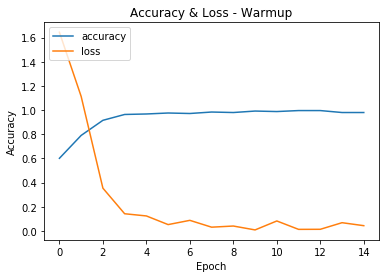

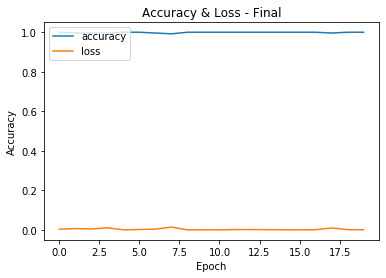

In [9]:
history_1.plot_title = "Warmup"
history_2.plot_title = "Final"

global_history = [history_1, history_2]

for history in global_history:
    # summarize history for accuracy
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['loss'], label='loss')
    plt.title("Accuracy & Loss - " + history.plot_title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

#### Predictions

Predicting...
Predcitions completed! # 70
              precision    recall  f1-score   support

     biofuel       0.78      1.00      0.88        35
 non_biofuel       1.00      0.71      0.83        35

    accuracy                           0.86        70
   macro avg       0.89      0.86      0.85        70
weighted avg       0.89      0.86      0.85        70

Normalized confusion matrix


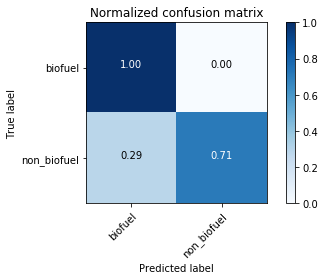

In [10]:
gc.collect()

# Make sure everything is okay
test_set.reset()
test_set.batch_size = 1
test_set.shuffle = False

# Can only handle 5 batch size perdictions (PAULO's GPU)
print("Predicting...")
img, label = next(test_set)
predictions = model.predict(img, verbose=0)

for i in range(len(test_set)-1):
    img, label = next(test_set)
    new_predictions = model.predict(img, verbose=0)
    predictions = np.concatenate((predictions, new_predictions))

print("Predcitions completed! #", len(predictions))
# Print out scikit report
normalised_predictions = np.argmax(predictions, axis=1)
print(lib.classification_report(test_set.classes, normalised_predictions, target_names=CLASSES))
lib.plot_confusion_matrix(test_set.classes, normalised_predictions, CLASSES)

In [11]:
model.save('app\\trained_models\\ResNet50')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: app\trained_models\ResNet50\assets
